# GradCAM: Continuation (Part 2) - Lecture Notebook

In the previous lecture notebook (GradCAM Part 1) we explored what Grad-Cam is and why it is useful. We also looked at how we can compute the activations of a particular layer using Keras API. In this notebook we will check the other element that Grad-CAM requires, the gradients of the model's output with respect to our desired layer's output. This is the "Grad" portion of Grad-CAM. 

Let's dive into it!

In [1]:
import keras
from keras import backend as K
from util import *

Using TensorFlow backend.


The `load_C3M3_model()` function has been taken care of and as last time, its internals are out of the scope of this notebook.

In [2]:
# Load the model we used last time
model = load_C3M3_model()

Got loss weights
Loaded DenseNet
Added layers
Compiled Model
Loaded Weights


Kindly recall from the previous notebook (GradCAM Part 1) that our model has 428 layers. 

We are now interested in getting the gradients when the model outputs a specific class. For this we will use Keras backend's `gradients(..)` function. This function requires two arguments: 

  - Loss (scalar tensor)
  - List of variables
  
Since we want the gradients with respect to the output, we can use our model's output tensor:

In [3]:
# Save model's output in a variable
y = model.output

# Print model's output
y

<tf.Tensor 'dense_1/Sigmoid:0' shape=(?, 14) dtype=float32>

However this is not a scalar (aka rank-0) tensor because it has axes. To transform this tensor into a scalar we can slice it like this:

In [4]:
y = y[0]
y

<tf.Tensor 'strided_slice:0' shape=(14,) dtype=float32>

It is still *not* a scalar tensor so we will have to slice it again:

In [5]:
y = y[0]
y

<tf.Tensor 'strided_slice_1:0' shape=() dtype=float32>

Now it is a scalar tensor!

The above slicing could be done in a single statement like this:

```python
y = y[0,0]
```

But the explicit version of it was shown for visibility purposes.

The first argument required by `gradients(..)` function is the loss, which we will like to get the gradient of, and the second is a list of parameters to compute the gradient with respect to. Since we are interested in getting the gradient of the output of the model with respect to the output of the last convolutional layer we need to specify the layer as we did  in the previous notebook:

In [6]:
# Save the desired layer in a variable
layer = model.get_layer("conv5_block16_concat")

# Compute gradient of model's output with respect to last conv layer's output
gradients = K.gradients(y, layer.output)

# Print gradients list
gradients

[<tf.Tensor 'gradients/AddN:0' shape=(?, ?, ?, 1024) dtype=float32>]

Notice that the gradients function returns a list of placeholder tensors. To get the actual placeholder we will get the first element of this list:

In [7]:
# Get first (and only) element in the list
gradients = gradients[0]

# Print tensor placeholder
gradients

<tf.Tensor 'gradients/AddN:0' shape=(?, ?, ?, 1024) dtype=float32>

As with the activations of the last convolutional layer in the previous notebook, we still need a function that uses this placeholder to compute the actual values for an input image. This can be done in the same manner as before. Remember this **function expects its arguments as lists or tuples**:

In [8]:
# Instantiate the function to compute the gradients
gradients_function = K.function([model.input], [gradients])

# Print the gradients function
gradients_function

Now that we have the function for computing the gradients, let's test it out on a particular image. Don't worry about the code to load the image, this has been taken care of for you, you should only care that an image ready to be processed will be saved in the x variable:

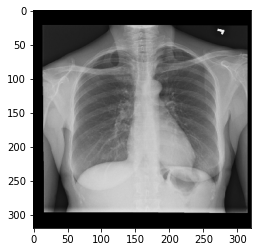

In [9]:
# Load dataframe that contains information about the dataset of images
df = pd.read_csv("nih_new/train-small.csv")

# Path to the actual image
im_path = 'nih_new/images-small/00000599_000.png'

# Load the image and save it to a variable
x = load_image(im_path, df, preprocess=False)

# Display the image
plt.imshow(x, cmap = 'gray')
plt.show()

We should normalize this image before going forward, this has also been taken care of:

In [10]:
# Calculate mean and standard deviation of a batch of images
mean, std = get_mean_std_per_batch(df)

# Normalize image
x = load_image_normalize(im_path, mean, std)

Now we have everything we need to compute the actual values of the gradients. In this case we should also **provide the input as a list or tuple**:

In [11]:
# Run the function on the image and save it in a variable
actual_gradients = gradients_function([x])

An important intermediary step is to trim the batch dimension which can be done like this:

In [12]:
# Remove batch dimension
actual_gradients = actual_gradients[0][0, :]

In [13]:
# Print shape of the gradients array
print(f"Gradients of model's output with respect to output of last convolutional layer have shape: {actual_gradients.shape}")

# Print gradients array
actual_gradients

Gradients of model's output with respect to output of last convolutional layer have shape: (10, 10, 1024)


array([[[-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05],
        [-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05],
        [-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05],
        ...,
        [-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05],
        [-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05],
        [-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05]],

       [[-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05],
        [-1.5285675e-09,  3.0796889e-09,  3.6089943e-07, ...,
          1.0077299e-04, -6.7449000e-05,  7.0278249e-05],
        [-1.5285675e-09, 

Looks like everything worked out nicely! You will still have to wait for the assignment to see how these elements are used by Grad-CAM to get visual interpretations. Before you go you should know that there is a shortcut for these calculations by getting both elements from a single Keras function:

In [14]:
# Save multi-input Keras function in a variable
activations_and_gradients_function = K.function([model.input], [layer.output, gradients])

# Run the function on our image
act_x, grad_x = activations_and_gradients_function([x])

# Remove batch dimension for both arrays
act_x = act_x[0, :]
grad_x = grad_x[0, :]

In [15]:
# Print actual activations
print(act_x)

# Print actual gradients
print(grad_x)

[[[-0.1937742   0.1255313  -0.14650567 ...  0.2015262  -0.07808703
    0.2279194 ]
  [-0.3451342  -0.47220397 -0.9109836  ...  0.2954995  -0.09030881
    0.3486008 ]
  [-0.2563844  -0.23169628 -0.9123602  ...  0.25490478 -0.08321017
    0.2946949 ]
  ...
  [-0.36403894 -0.27209273 -0.90169287 ...  0.14891046 -0.10215777
    0.19185728]
  [-0.2136532   0.00982342 -0.54579973 ...  0.29993278 -0.1248074
    0.34299296]
  [-0.20051737  0.2627251  -0.10944591 ...  0.15971167 -0.07640409
    0.2325058 ]]

 [[-0.350897    0.03020739 -0.5248743  ...  0.26196963 -0.12422886
    0.33092564]
  [-0.14692104 -0.36695045 -0.27806476 ...  0.44407526 -0.15437415
    0.5182152 ]
  [-0.44484276 -0.40406334 -0.41200617 ...  0.27413642 -0.12239916
    0.35573584]
  ...
  [-0.306549   -0.55498505 -0.550472   ...  0.17499827 -0.1236039
    0.21491493]
  [-0.48988265 -0.8998034  -0.5801711  ...  0.33734873 -0.14483741
    0.3449689 ]
  [-0.52365446 -0.1793406  -0.00435877 ...  0.19594473 -0.0742183
    0.231

**Congratulations on finishing this lecture notebook!** Hopefully you will now have a better understanding of how to leverage Keras's API power for computing gradients. Keep it up!